In [1]:
import os
import uproot
import glob
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC

2025-07-23 15:43:22.335345: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 15:43:22.368890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-23 15:43:22.368915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-23 15:43:22.368922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 15:43:22.374070: I tensorflow/core/platform/cpu_feature_g

In [ ]:
"""
# Base directory for all ROOT files
base_dir = "/home/sgoswami/monobcntuples/run3_btag/all"

# Signal and background files
signal_pattern = os.path.join(base_dir, "singlestop/basicSel_sT_tN1_*.root")
background_file = os.path.join(base_dir, "znunu/basicSel_znunu.root")

# Variables to load from TTree "sel_tree"
selected_variables = [
    "jet1_pt", "jet2_pt", "jet1met_dphi", "jet2met_dphi",
    "met_pt", "met_sig",
]
def load_root_data(file_list, label, tree_name="sel_tree", max_samples=None):
    data_frames = []
    for f in file_list:
        try:
            with uproot.open(f) as rootfile:
                if tree_name not in rootfile:
                    print(f"Skipping {f} — no '{tree_name}' found.")
                    continue
                tree = rootfile[tree_name]
                arrays = tree.arrays(selected_variables, library="ak")
                df = ak.to_dataframe(arrays).reset_index(drop=True)
                df = df.sample(frac=1).reset_index(drop=True)
                if max_samples:
                    df = df.iloc[:max_samples]
                data_frames.append(df)
        except Exception as e:
            print(f"Error reading {f}: {e}")

    if not data_frames:
        raise RuntimeError("No valid ROOT files loaded.")

    combined_df = pd.concat(data_frames, axis=0)
    labels = np.full((len(combined_df), 1), label)
    return combined_df, labels
# Load signal
signal_files = glob.glob(signal_pattern)
signal_df, signal_labels = load_root_data(signal_files, label=1)
signal_count = len(signal_df)

# Load background (balanced to signal count)
background_df, background_labels = load_root_data([background_file], label=0, max_samples=signal_count)

# Combine
X = pd.concat([signal_df, background_df], axis=0)
y = np.vstack((signal_labels, background_labels)).flatten()
"""

In [ ]:
"""
import os
import glob
import uproot
import awkward as ak
import pandas as pd
import numpy as np

# Base directory for all ROOT files
base_dir = "/home/sgoswami/monobcntuples/run3_btag/all"

# Signal: only load ROOT files, exclude _histogram.root
signal_pattern = os.path.join(base_dir, "singlestop/basicSel_sT_tN1_*.root")
signal_files = [f for f in glob.glob(signal_pattern) if "_histogram" not in os.path.basename(f)]

# Background directories to include (excluding singlestop and data)
background_dirs = ["diboson", "dijet", "singletop", "ttbar", "wlnu", "zll", "znunu"]

# Variables to load from TTree
selected_variables = [
    "jet1_pt", "jet2_pt", "jet1met_dphi", "jet2met_dphi",
    "met_pt", "met_sig",
]

def load_root_data(file_list, label, tree_name="sel_tree", max_samples=None):
    data_frames = []
    for f in file_list:
        try:
            with uproot.open(f) as rootfile:
                if tree_name not in rootfile:
                    print(f"Skipping {f} — no '{tree_name}' found.")
                    continue
                tree = rootfile[tree_name]
                arrays = tree.arrays(selected_variables, library="ak")
                df = ak.to_dataframe(arrays).reset_index(drop=True)
                df = df.sample(frac=1).reset_index(drop=True)
                if max_samples:
                    df = df.iloc[:max_samples]
                data_frames.append(df)
        except Exception as e:
            print(f"Error reading {f}: {e}")

    if not data_frames:
        raise RuntimeError("No valid ROOT files loaded.")

    combined_df = pd.concat(data_frames, axis=0)
    labels = np.full((len(combined_df), 1), label)
    return combined_df, labels

# Load signal
signal_df, signal_labels = load_root_data(signal_files, label=1)
signal_count = len(signal_df)

# Collect and filter background files
bg_files = []
for d in background_dirs:
    full_dir = os.path.join(base_dir, d)
    root_files = glob.glob(os.path.join(full_dir, "*.root"))
    for f in root_files:
        base = os.path.basename(f)
        if "_histogram" not in base and "singlestop" not in f:
            bg_files.append(f)

# Load background (balanced to signal)
background_df, background_labels = load_root_data(bg_files, label=0, max_samples=signal_count)

# Combine
X = pd.concat([signal_df, background_df], axis=0)
y = np.vstack((signal_labels, background_labels)).flatten()
"""

Found 3 signal files.
Loaded 175651 signal events.
Post‑fit background totals:
  zll       :    10311.5
  znunu     :   702063.8
  wlnu      :   516779.0
  diboson   :    16351.9
  dijet     :     6060.9
  singletop :    11706.1
  ttbar     :    55420.2

Derived sampling proportions (sum→1):
  zll       : 0.0078
  znunu     : 0.5324
  wlnu      : 0.3919
  diboson   : 0.0124
  dijet     : 0.0046
  singletop : 0.0089
  ttbar     : 0.0420

Background files found per process:
  zll       :   1 files
  znunu     :   1 files
  wlnu      :   1 files
  diboson   :   1 files
  dijet     :   1 files
  singletop :   1 files
  ttbar     :   1 files

Loading 'zll' files:
  basicSel_zll.root              → 77810 events

Loading 'znunu' files:
  basicSel_znunu.root            → 2410060 events

Loading 'wlnu' files:
  basicSel_wlnu.root             → 302016 events

Loading 'diboson' files:
  basicSel_diboson.root          → 170355 events

Loading 'dijet' files:
  basicSel_dijet.root            → 29388

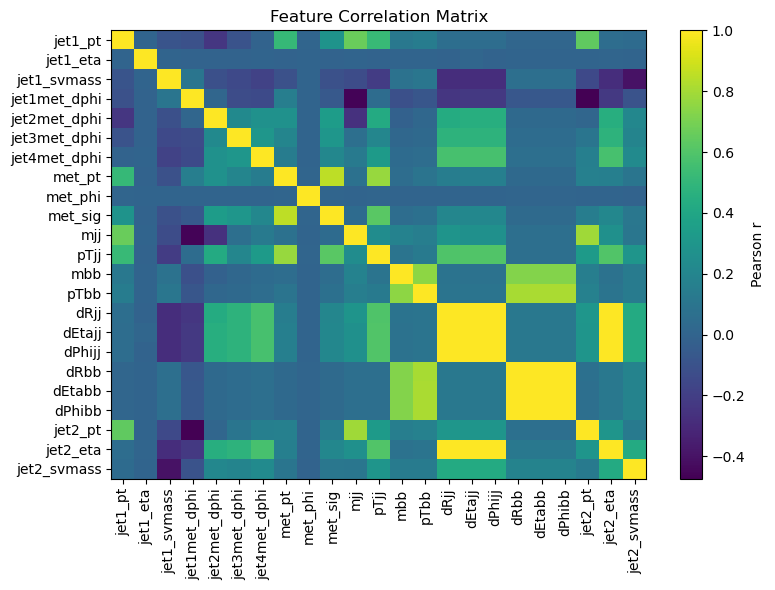

Feature scaling complete.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3072      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_5 (Bat 

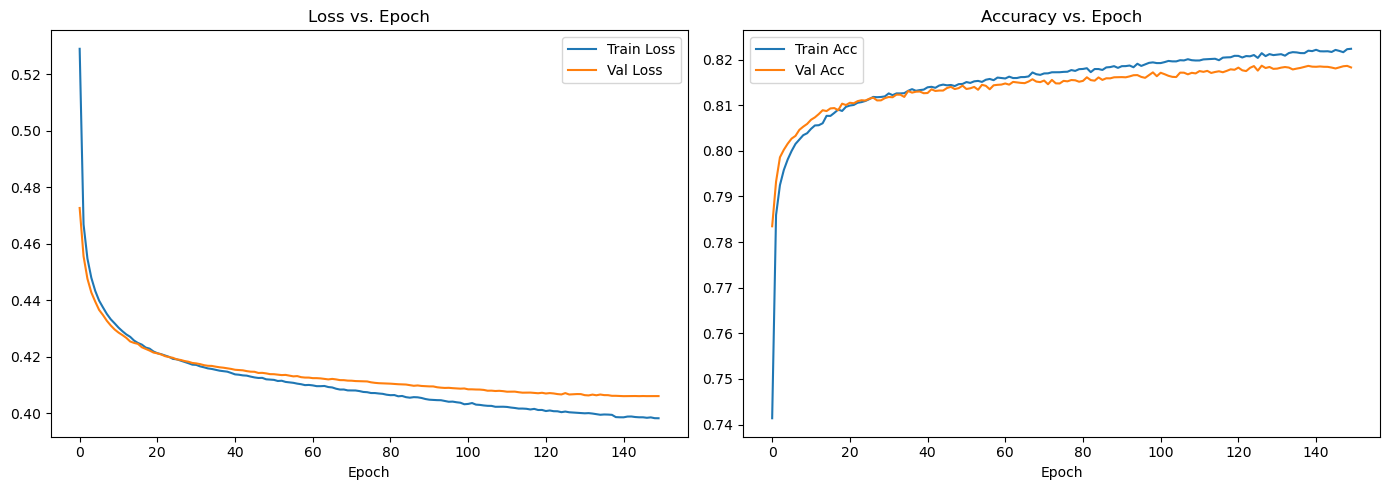

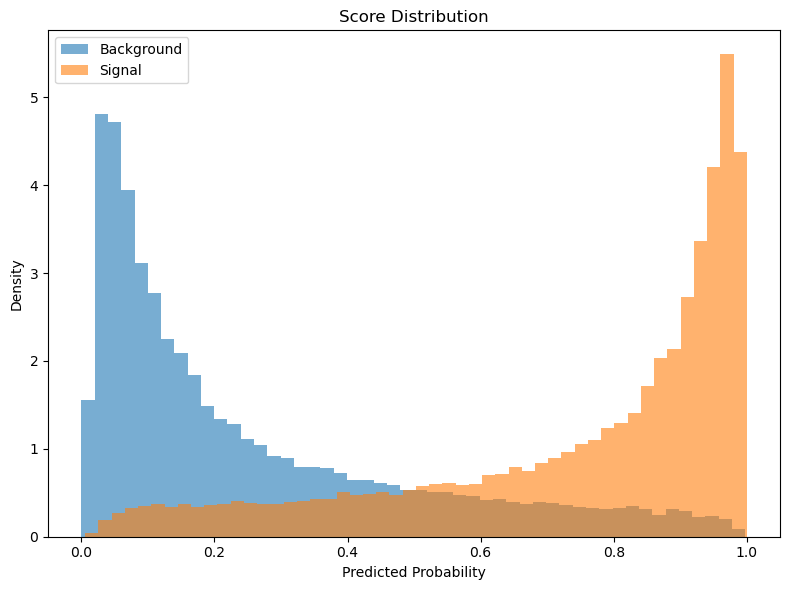

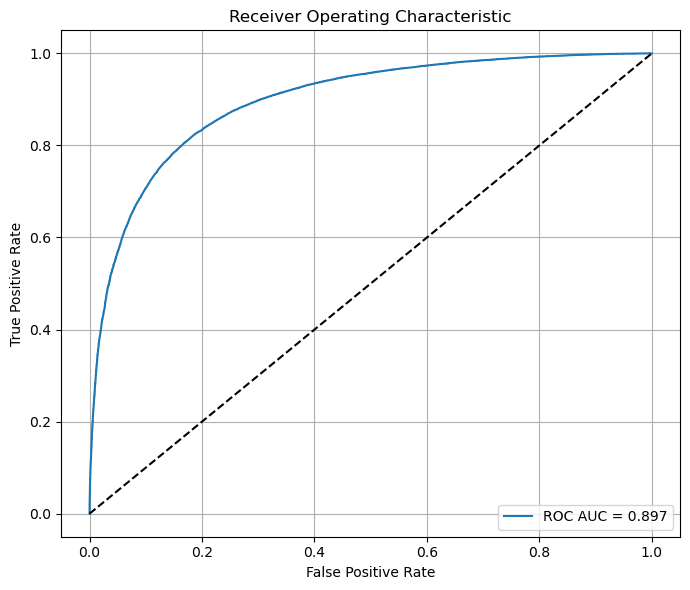

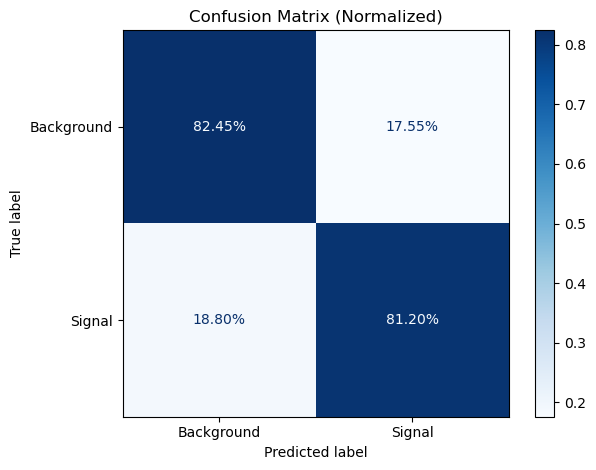

Threshold scan (signal efficiency / background rejection):
  Threshold=0.20: signal eff=0.942, background rej=0.571
  Threshold=0.30: signal eff=0.904, background rej=0.685
  Threshold=0.40: signal eff=0.862, background rej=0.764
  Threshold=0.50: signal eff=0.812, background rej=0.825


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, classification_report
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall

# --- Configuration ---
"""
selected_variables = [
    "jet1_pt", "jet2_pt", "jet1met_dphi", "jet2met_dphi",
    "met_pt", "met_sig", "jet1_eta"
]
"""
selected_variables = [
    "jet1_pt", "jet1_eta", "jet1_svmass", "jet1met_dphi", "jet2met_dphi",
    "jet3met_dphi", "jet4met_dphi", "met_pt", "met_phi", "met_sig", "mjj",
    "pTjj", "mbb", "pTbb", "dRjj", "dEtajj", "dPhijj", "dRbb", "dEtabb",
    "dPhibb", "jet2_pt", "jet2_eta", "jet2_svmass"
]
# --- Original ROOT loader (UNCHANGED) ---
def load_root_data(file_list, label, tree_name="sel_tree", max_samples=None):
    dfs = []
    for f in file_list:
        try:
            with uproot.open(f) as rootfile:
                if tree_name not in rootfile:
                    print(f"Skipping {f} — no '{tree_name}' found.")
                    continue
                arr = rootfile[tree_name].arrays(selected_variables, library="ak")
                df = ak.to_dataframe(arr).reset_index(drop=True)
                df = df.sample(frac=1).reset_index(drop=True)
                if max_samples:
                    df = df.iloc[:max_samples]
                dfs.append(df)
        except Exception as e:
            print(f"Error reading {f}: {e}")
    if not dfs:
        raise RuntimeError("No valid ROOT files loaded.")
    combined_df = pd.concat(dfs, axis=0).reset_index(drop=True)
    labels = np.full((len(combined_df), 1), label)
    return combined_df, labels

# --- Importance shuffle ---
def importance_shuffle(X, y=None):
    idx = np.random.permutation(len(X))
    Xs = X.iloc[idx].reset_index(drop=True)
    if y is None:
        return Xs
    return Xs, y[idx]

# --- File setup ---
base_dir = "/home/sgoswami/monobcntuples/run3_btag/all"
signal_pattern = os.path.join(base_dir, "singlestop/basicSel_sT_tN1_*.root")
background_dirs = ["diboson", "dijet", "singletop", "ttbar", "wlnu", "zll", "znunu"]

# --- Signal loading ---
signal_files = [f for f in glob.glob(signal_pattern) if "_histogram" not in os.path.basename(f)]
print(f"Found {len(signal_files)} signal files.")
signal_df, signal_labels = load_root_data(signal_files, label=1)
print(f"Loaded {len(signal_df)} signal events.")

# --- Background loading ---
# === Post‑fit totals from all five SR bins (from your uploaded plots) ===
postfit_totals = {
    'zll'      : 10311.5,
    'znunu'    : 702063.8,
    'wlnu'     : 516779.0,
    'diboson'  : 16351.9,
    'dijet'    :  6060.9,
    'singletop': 11706.1,
    'ttbar'    : 55420.2,
}

# 1) Print totals
print("Post‑fit background totals:")
for proc, tot in postfit_totals.items():
    print(f"  {proc:10s}: {tot:10.1f}")

# 2) Compute sampling proportions
total_pf = sum(postfit_totals.values())
bkg_proportions = {proc: tot/total_pf for proc, tot in postfit_totals.items()}

print("\nDerived sampling proportions (sum→1):")
for proc, prop in bkg_proportions.items():
    print(f"  {proc:10s}: {prop:.4f}")

# 3) Build list of files per process (as before)
bg_files_map = {
    proc: [
        f for f in glob.glob(os.path.join(base_dir, proc, "*.root"))
        if "_histogram" not in os.path.basename(f)
           and "singlestop" not in os.path.basename(f)
    ]
    for proc in postfit_totals
}

print("\nBackground files found per process:")
for proc, files in bg_files_map.items():
    print(f"  {proc:10s}: {len(files):3d} files")

# 4) Load all events per process
proc_dfs = {}
for proc, files in bg_files_map.items():
    dfs = []
    print(f"\nLoading '{proc}' files:")
    for f in files:
        df_f, _ = load_root_data([f], label=0)
        print(f"  {os.path.basename(f):30s} → {len(df_f):5d} events")
        dfs.append(df_f)
    proc_dfs[proc] = pd.concat(dfs, axis=0).reset_index(drop=True)

# 5) Determine how many background events to sample per process (S:B = 1:1)
S = len(signal_df)
print(f"\nSignal count (S) = {S}")
sample_counts = {
    proc: int(round(S * bkg_proportions[proc]))
    for proc in postfit_totals
}

# adjust last to ensure exact sum = S
diff = S - sum(sample_counts.values())
last_proc = list(sample_counts.keys())[-1]
sample_counts[last_proc] += diff

print("\nBackground sampling targets per process:")
for proc, n in sample_counts.items():
    print(f"  {proc:10s}: {n:5d}")

# 6) Sample from each process (with replacement if needed), then combine
sampled_parts = []
for proc, df_proc in proc_dfs.items():
    n = sample_counts[proc]
    if n > 0 and len(df_proc) > 0:
        df_samp = df_proc.sample(
            n=n,
            replace=(n > len(df_proc)),
            random_state=42
        ).reset_index(drop=True)
    else:
        df_samp = pd.DataFrame(columns=df_proc.columns)
    sampled_parts.append(df_samp)
    print(f"Sampled {len(df_samp):5d} events from '{proc}'")

background_df = pd.concat(sampled_parts, axis=0).reset_index(drop=True)
background_labels = np.zeros(len(background_df), dtype=int)
print(f"\nTotal sampled background events: {len(background_df)}")

# 7) Shuffle final background
# build background_labels as a column vector
background_labels = np.full((len(background_df), 1), 0)

# shuffle DataFrame and labels in unison
background_df, background_labels = importance_shuffle(background_df, background_labels)
print("Shuffled sampled background events.")

# then this will work:
X = pd.concat([signal_df, background_df], axis=0).reset_index(drop=True)
y = np.vstack((signal_labels, background_labels)).flatten()

print(f"Total dataset: {len(X)} events; class counts: {np.bincount(y)}")

X_shuf, y_shuf = importance_shuffle(X, y)
print("Dataset shuffled with importance_shuffle().")

# --- Train/Validation split ---
X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_shuf, y_shuf,
    test_size=0.2,
    stratify=y_shuf,
    shuffle=True,
    random_state=42
)
print(f"Train events: {X_train_df.shape[0]}, Val events: {X_val_df.shape[0]}")
print(f"Train class dist: {np.bincount(y_train)}, Val class dist: {np.bincount(y_val)}")

# --- DataFrame diagnostics ---
print("\nTraining data summary:")
print(X_train_df.describe().transpose())
print("\nMissing values in training data:")
print(X_train_df.isna().sum())

# --- Correlation matrix ---
corr = X_train_df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, interpolation='none', aspect='auto')
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
fig.colorbar(im, ax=ax, label="Pearson r")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# --- Scaling ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df.values)
X_val   = scaler.transform(X_val_df.values)
y_train = y_train.ravel()
y_val   = y_val.ravel()
print("Feature scaling complete.")

# --- Model definition ---
def build_model(input_dim):
    return Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='gelu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dense(64, activation='gelu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dense(32, activation='gelu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dense(1, activation='sigmoid', kernel_initializer='he_normal'),
    ])

model = build_model(X_train.shape[1])
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), 'accuracy', Precision(name='precision'), Recall(name='recall')]
)
model.summary()

# --- Callbacks (weights-only checkpoint) ---
callbacks = [
    EarlyStopping(monitor='val_auc', patience=20, mode='max',
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=7,
                      min_lr=1e-7, mode='max', verbose=1),
    ModelCheckpoint("best_weights.ckpt", save_best_only=True,
                    save_weights_only=True, verbose=1)
]

# --- Training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=512,
    callbacks=callbacks,
    verbose=1
)
print("\nTraining complete; weights saved to 'best_weights.ckpt'.")

# --- Save full model ---
model.save("best_model_stop.keras", save_format="keras")
print("Full model saved as 'best_model_stop.keras'.")

# --- Classification report ---
y_val_pred = model.predict(X_val).ravel()
y_val_class = (y_val_pred > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_val, y_val_class, target_names=["Background", "Signal"]))

# --- Plot training history ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Loss vs. Epoch'); ax1.set_xlabel('Epoch'); ax1.legend()
ax2.plot(history.history['accuracy'], label='Train Acc')
ax2.plot(history.history['val_accuracy'], label='Val Acc')
ax2.set_title('Accuracy vs. Epoch'); ax2.set_xlabel('Epoch'); ax2.legend()
plt.tight_layout(); plt.show()

# --- Score distributions ---
plt.figure(figsize=(8,6))
plt.hist(y_val_pred[y_val==0], bins=50, alpha=0.6, label='Background', density=True)
plt.hist(y_val_pred[y_val==1], bins=50, alpha=0.6, label='Signal', density=True)
plt.xlabel('Predicted Probability'); plt.ylabel('Density')
plt.title('Score Distribution'); plt.legend(); plt.tight_layout(); plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right'); plt.grid(True); plt.tight_layout(); plt.show()

# --- Normalized Confusion Matrix ---
cm_pct = confusion_matrix(y_val, y_val_class, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pct, display_labels=["Background", "Signal"])
disp.plot(cmap='Blues', values_format='.2%')
plt.title("Confusion Matrix (Normalized)"); plt.tight_layout(); plt.show()

# --- Threshold scan ---
print("Threshold scan (signal efficiency / background rejection):")
for t in [0.2, 0.3, 0.4, 0.5]:
    sig_eff = np.mean(y_val_pred[y_val==1] > t)
    bkg_rej = np.mean(y_val_pred[y_val==0] <= t)
    print(f"  Threshold={t:.2f}: signal eff={sig_eff:.3f}, background rej={bkg_rej:.3f}")

--- Calculating and Plotting Permutation Feature Importance ---
Baseline Validation AUC: 0.8968

Feature importances (drop in AUC):
     feature  importance
      met_pt    0.227509
     met_sig    0.071212
         mjj    0.071046
     jet1_pt    0.044719
         mbb    0.044671
     jet2_pt    0.042748
      dPhibb    0.034740
        pTjj    0.031028
        dRbb    0.029491
        dRjj    0.028939
        pTbb    0.027995
    jet2_eta    0.019812
      dPhijj    0.016869
      dEtajj    0.015831
      dEtabb    0.015725
jet2met_dphi    0.014822
jet1met_dphi    0.011965
 jet2_svmass    0.009895
 jet1_svmass    0.008299
jet3met_dphi    0.008056
jet4met_dphi    0.004915
    jet1_eta    0.003832
     met_phi   -0.000009


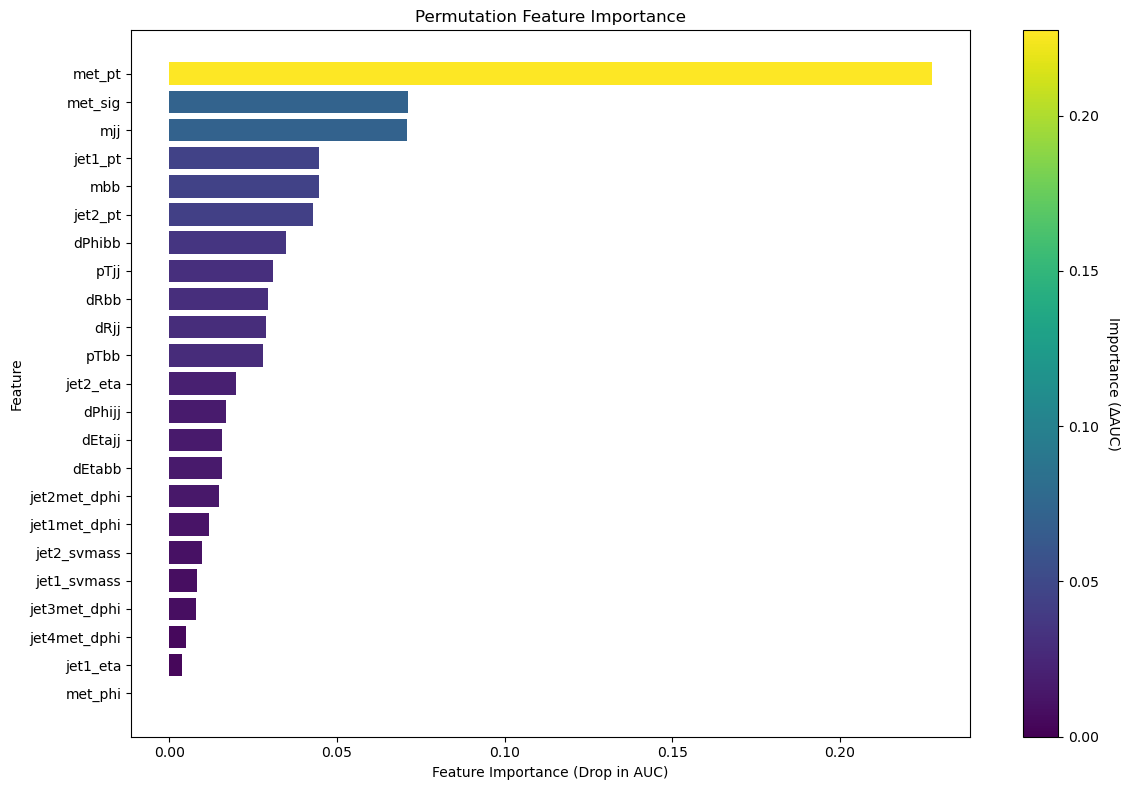

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_auc_score

print("--- Calculating and Plotting Permutation Feature Importance ---")

# load your trained model
model = tf.keras.models.load_model('best_model_stop.keras')
batch_size=512
# baseline AUC
y_pred_baseline = model.predict(X_val, batch_size=batch_size, verbose=0).squeeze()
baseline_auc = roc_auc_score(y_val, y_pred_baseline)
print(f"Baseline Validation AUC: {baseline_auc:.4f}\n")

# permutation loop
np.random.seed(42)
importances = []
for i in range(X_val.shape[1]):
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, i])
    y_pred_permuted = model.predict(X_val_permuted, batch_size=batch_size, verbose=0).squeeze()
    permuted_auc = roc_auc_score(y_val, y_pred_permuted)
    importances.append(baseline_auc - permuted_auc)

# build DataFrame and sort descending
importance_df = (
    pd.DataFrame({
        'feature': selected_variables,
        'importance': importances
    })
    .sort_values(by='importance', ascending=False)
    .reset_index(drop=True)
)

# print out all feature importances
print("Feature importances (drop in AUC):")
print(importance_df.to_string(index=False))

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(
    vmin=importance_df['importance'].min(),
    vmax=importance_df['importance'].max()
)

ax.barh(
    importance_df['feature'],
    importance_df['importance'],
    color=cmap(norm(importance_df['importance']))
)
ax.invert_yaxis()  # highest at top

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Importance (ΔAUC)', rotation=270, labelpad=15)

ax.set_xlabel("Feature Importance (Drop in AUC)")
ax.set_ylabel("Feature")
ax.set_title("Permutation Feature Importance")
fig.tight_layout()
plt.show()

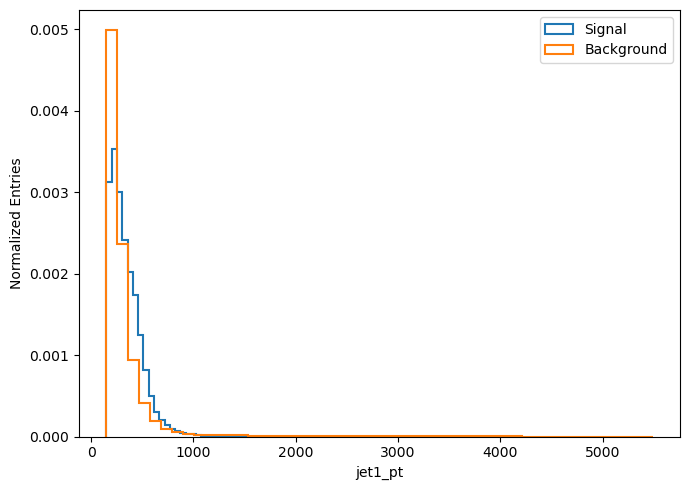

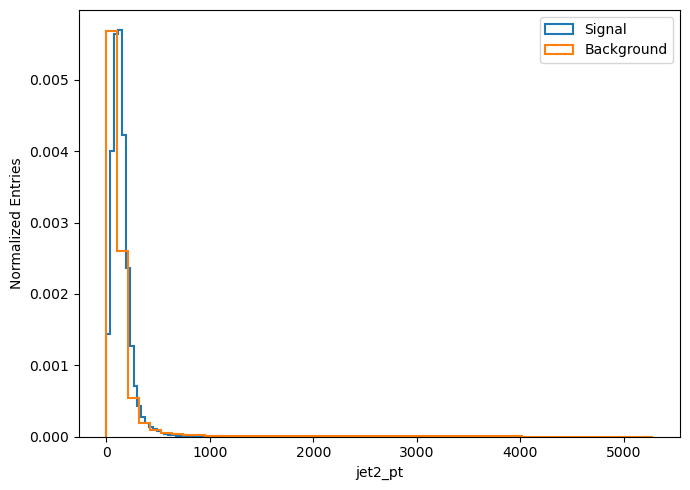

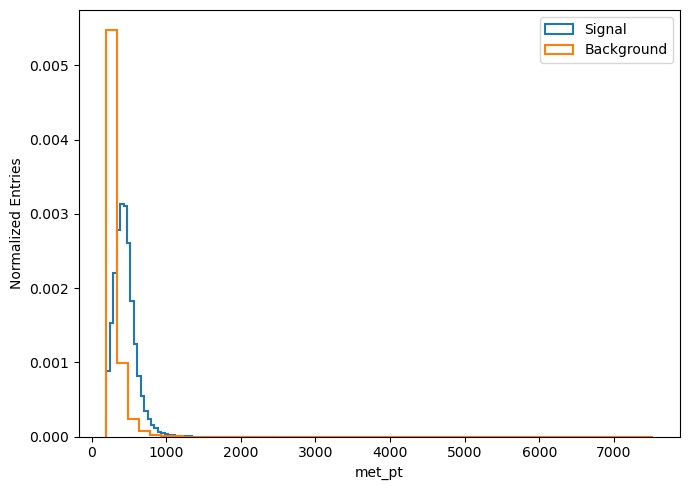

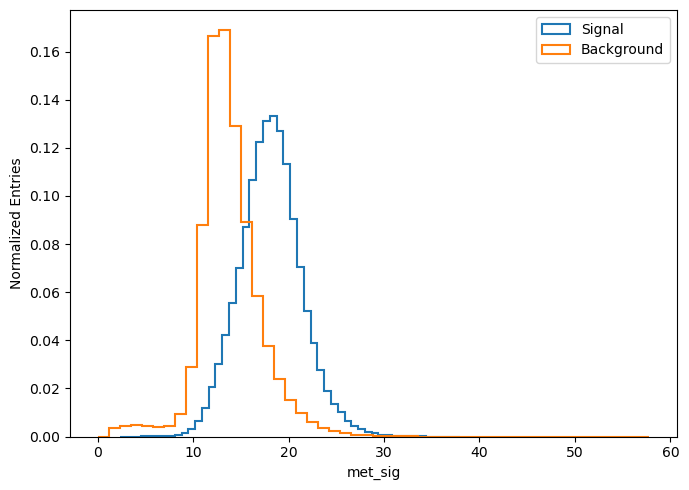

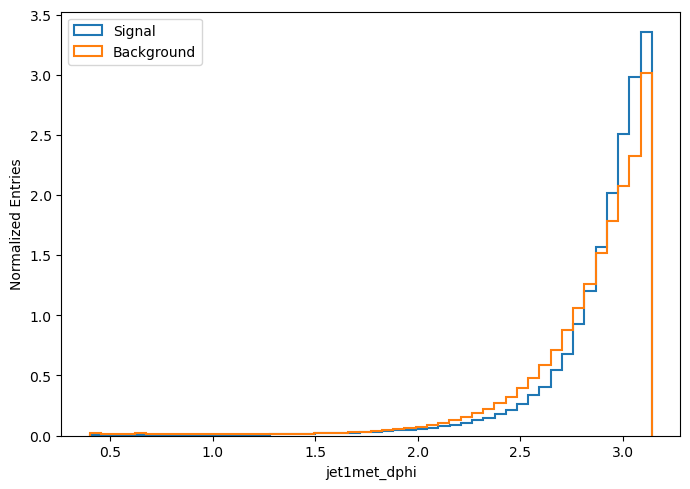

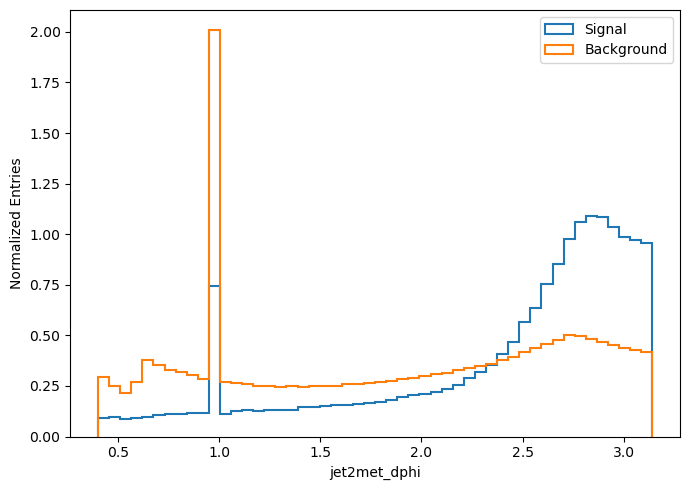

In [8]:
def plot_variable(var_name, bins=50):
    plt.figure(figsize=(7, 5))
    plt.hist(signal_df[var_name], bins=bins, density=True, histtype='step', label='Signal', linewidth=1.5)
    plt.hist(background_df[var_name], bins=bins, density=True, histtype='step', label='Background', linewidth=1.5)
    plt.xlabel(var_name)
    plt.ylabel("Normalized Entries")
    plt.legend()
    plt.tight_layout()
    plt.show()

selected_variables = [
    "jet1_pt",          # already present
    "jet2_pt",          # already present
    "jet1met_dphi",     # already present
    "jet2met_dphi",     # already present
    "met_pt",           # already present
    "met_sig",          # already present
]

# Example usage
plot_variable("jet1_pt")
plot_variable("jet2_pt")
plot_variable("met_pt")
plot_variable("met_sig")
plot_variable("jet1met_dphi")
plot_variable("jet2met_dphi")


Data integrity check:


NameError: name 'X_train_df' is not defined